In [ ]:
!pip install ts2vg
!pip install igraph

In [ ]:
#mount google drive to colab
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#required libraries
import pandas as pd
import numpy as np
from ts2vg import NaturalVG
from ts2vg import HorizontalVG
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

In [ ]:
#setting directory to access the files
%cd /content/drive/MyDrive/Thigh

/content/drive/MyDrive/Thigh


# **TASK 1**

In [ ]:
#Creating Lists for activities,subjects,method and axis
Activity = ["climbingup","climbingdown","walking","running"]
Subject = ["S1","S2","S3","S4","S5","S6","S7","S8","S9","S10","S11","S12","S13","S14","S15"]
Method = [NaturalVG,HorizontalVG]
Axis = ["x","y","z"]

In [ ]:
dframe_columns = ["Method","Subject","Activity","Axis","Average Degree","Network Diameter","Average Path Length"]
df_task1=pd.DataFrame(columns=dframe_columns)

In [ ]:
#to build the dataframe for subjects, activity,methods and axis

for Sub in Subject:
  for Act in Activity:
    Filename = "acc_"+Act+"_thigh_"+Sub+".csv"
    df = pd.read_csv(Filename)
    for m in Method:  
      for ax in Axis:
        temp=df["attr_"+ax][1000:2024]
        g=m();
        g.build(temp)
        ig_m = g.as_igraph()
        temp1 ={"Method":m.__name__,"Subject":Sub,"Activity":Act,"Axis":ax,"Average Degree":np.mean(ig_m.degree()),"Network Diameter":ig_m.diameter(),"Average Path Length":ig_m.average_path_length()}
        df_task1 = df_task1.append(temp1, ignore_index=True)
      

In [ ]:
#display DATAFRAME
df_task1

,Method,Subject,Activity,Axis,Average Degree,Network Diameter,Average Path Length
0,NaturalVG,S1,climbingup,x,9.292969,11,4.338794
1,NaturalVG,S1,climbingup,y,9.906250,11,5.070387
2,NaturalVG,S1,climbingup,z,10.417969,10,4.800959
3,HorizontalVG,S1,climbingup,x,3.958984,26,11.309583
4,HorizontalVG,S1,climbingup,y,3.960938,22,10.397664
...,...,...,...,...,...,...,...
355,NaturalVG,S15,running,y,7.226562,11,5.162014
356,NaturalVG,S15,running,z,7.318359,11,5.095928
357,HorizontalVG,S15,running,x,3.884766,58,20.463366
358,HorizontalVG,S15,running,y,3.960938,22,8.111746


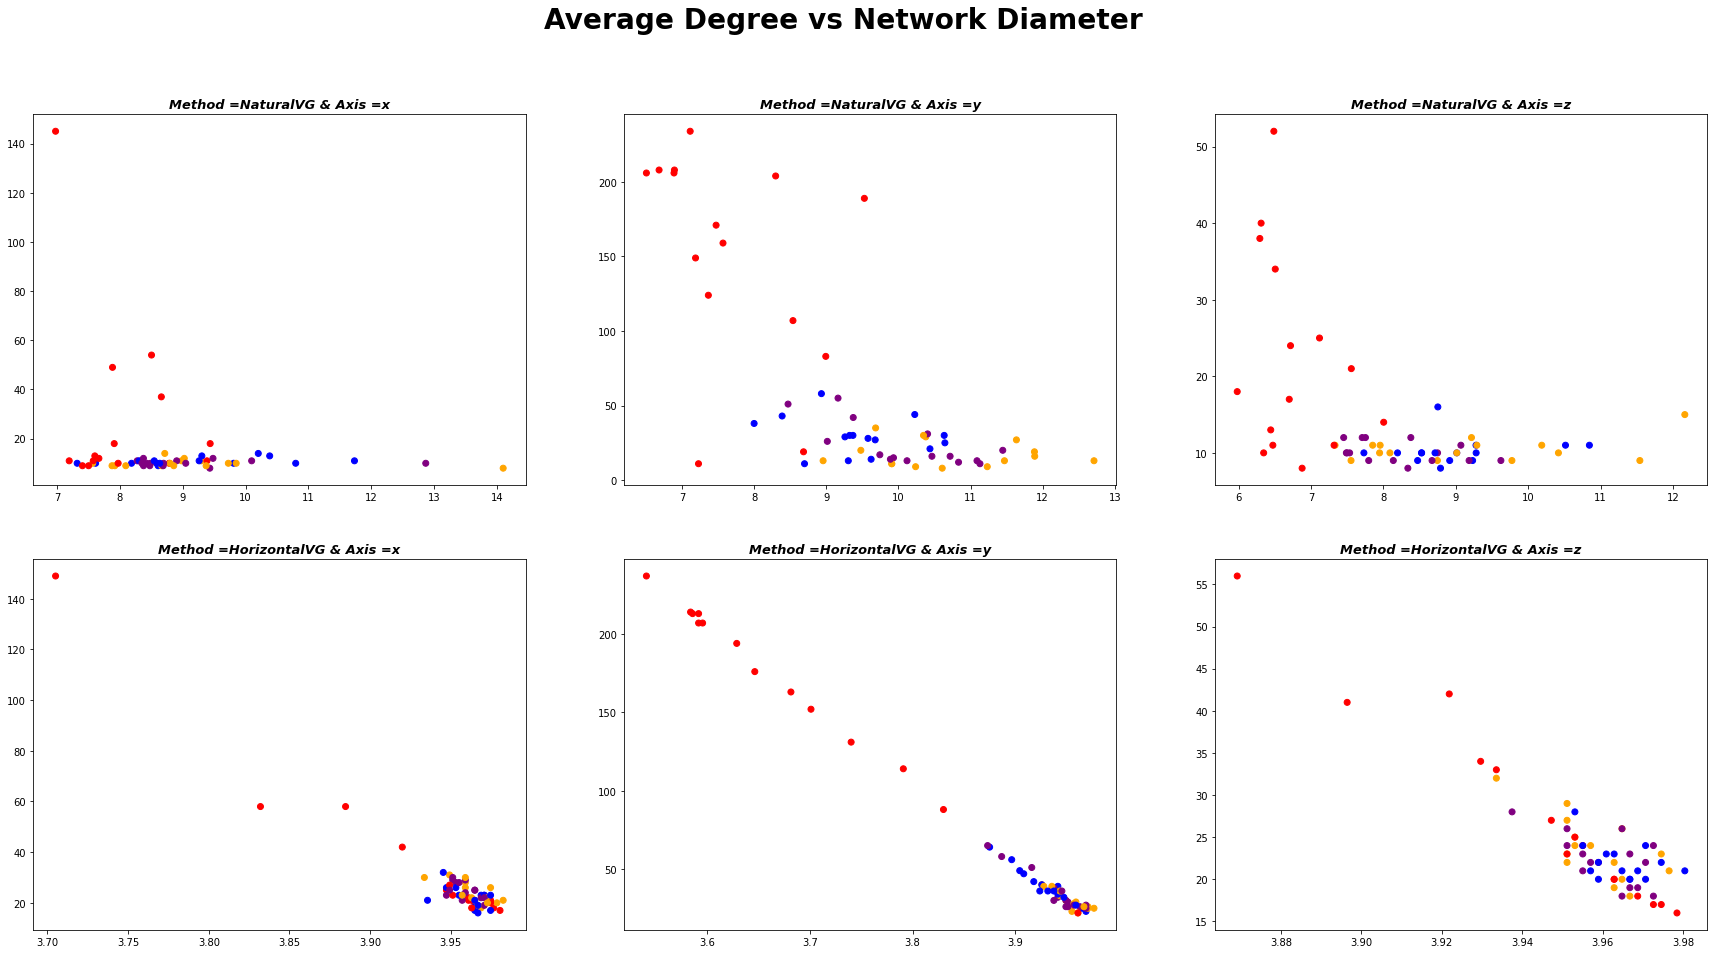

In [ ]:
# Plotting the Average Degree vs Network Diameter for all activities for eaxh axis

plot,axis = plt.subplots(2,3,figsize=(30,15))
plot.suptitle("Average Degree vs Network Diameter",size=28, weight="bold", color="black")
Method = ["NaturalVG","HorizontalVG"]
A = ["x","y","z"]
Activity = ["walking","running","climbingup","climbingdown"]
#Colors for different activities
cols={"walking":"blue","running":"red","climbingup":"orange","climbingdown":"purple"}
a=0;
for m in Method:
  b=0  
  for ax in A:
    title="Method ="+m+" & Axis ="+ax;
    axis[a,b].set_title(title, fontstyle='italic',size=13, weight="bold", color="black")
    df1=df_task1[(df_task1["Method"]==m) & (df_task1["Axis"]==ax)]
    axis[a,b].scatter(x=df1["Average Degree"], y=df1["Network Diameter"], c=df1["Activity"].map(cols))
    b+=1;
  a+=1      

# **TASK 2**

## Permutation Entropy 

In [ ]:
def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*m-1):, :] 
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:]) 
    

def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

## DF

In [ ]:
#Creating Lists
Activity = ["climbingup","climbingdown","walking","running"]
Subject = ["S1","S2","S3","S4","S5","S6","S7","S8","S9","S10","S11","S12","S13","S14","S15"]
Axis = ["x","y","z"]
Dimension =[3,4,5,6]
Delay = [1,2,3]
Signal = [1024,2048,4096]

In [ ]:
#Creating empty dataframe with colnames
Col_Names = ["Subject","Accelerometer Axis","Signal Length","Dimension","Delay","Permutation Entropy","Complexity","Activity"]
df_task2=pd.DataFrame(columns=Col_Names)

In [ ]:
#for loop to access files for each subjects and append the data to dataframe
for Sub in Subject:
  for Act in Activity:
    Filename = "acc_"+Act+"_thigh_"+Sub+".csv"
    df = pd.read_csv(Filename)
    for ax in Axis:
      for s in Signal:
        for D in Dimension:
          for d in Delay:
            op = ordinal_patterns(df["attr_"+ax][0:s],D,d)
            temp ={"Subject":Sub,"Accelerometer Axis":ax,"Signal Length":s,"Dimension":D,"Delay":d,"Permutation Entropy":p_entropy(op),"Complexity":complexity(op),"Activity":Act}
            df_task2 = df_task2.append(temp, ignore_index=True)


In [ ]:
df_task2

,Subject,Accelerometer Axis,Signal Length,Dimension,Delay,Permutation Entropy,Complexity,Activity
0,S1,x,1024,3,1,0.951783,0.044223,climbingup
1,S1,x,1024,3,2,0.988608,0.010915,climbingup
2,S1,x,1024,3,3,0.996087,0.003825,climbingup
3,S1,x,1024,4,1,0.921604,0.089973,climbingup
4,S1,x,1024,4,2,0.975054,0.032596,climbingup
...,...,...,...,...,...,...,...,...
6475,S15,z,4096,5,2,0.875128,0.181315,running
6476,S15,z,4096,5,3,0.844056,0.230183,running
6477,S15,z,4096,6,1,0.899459,0.176755,running
6478,S15,z,4096,6,2,0.867734,0.225423,running


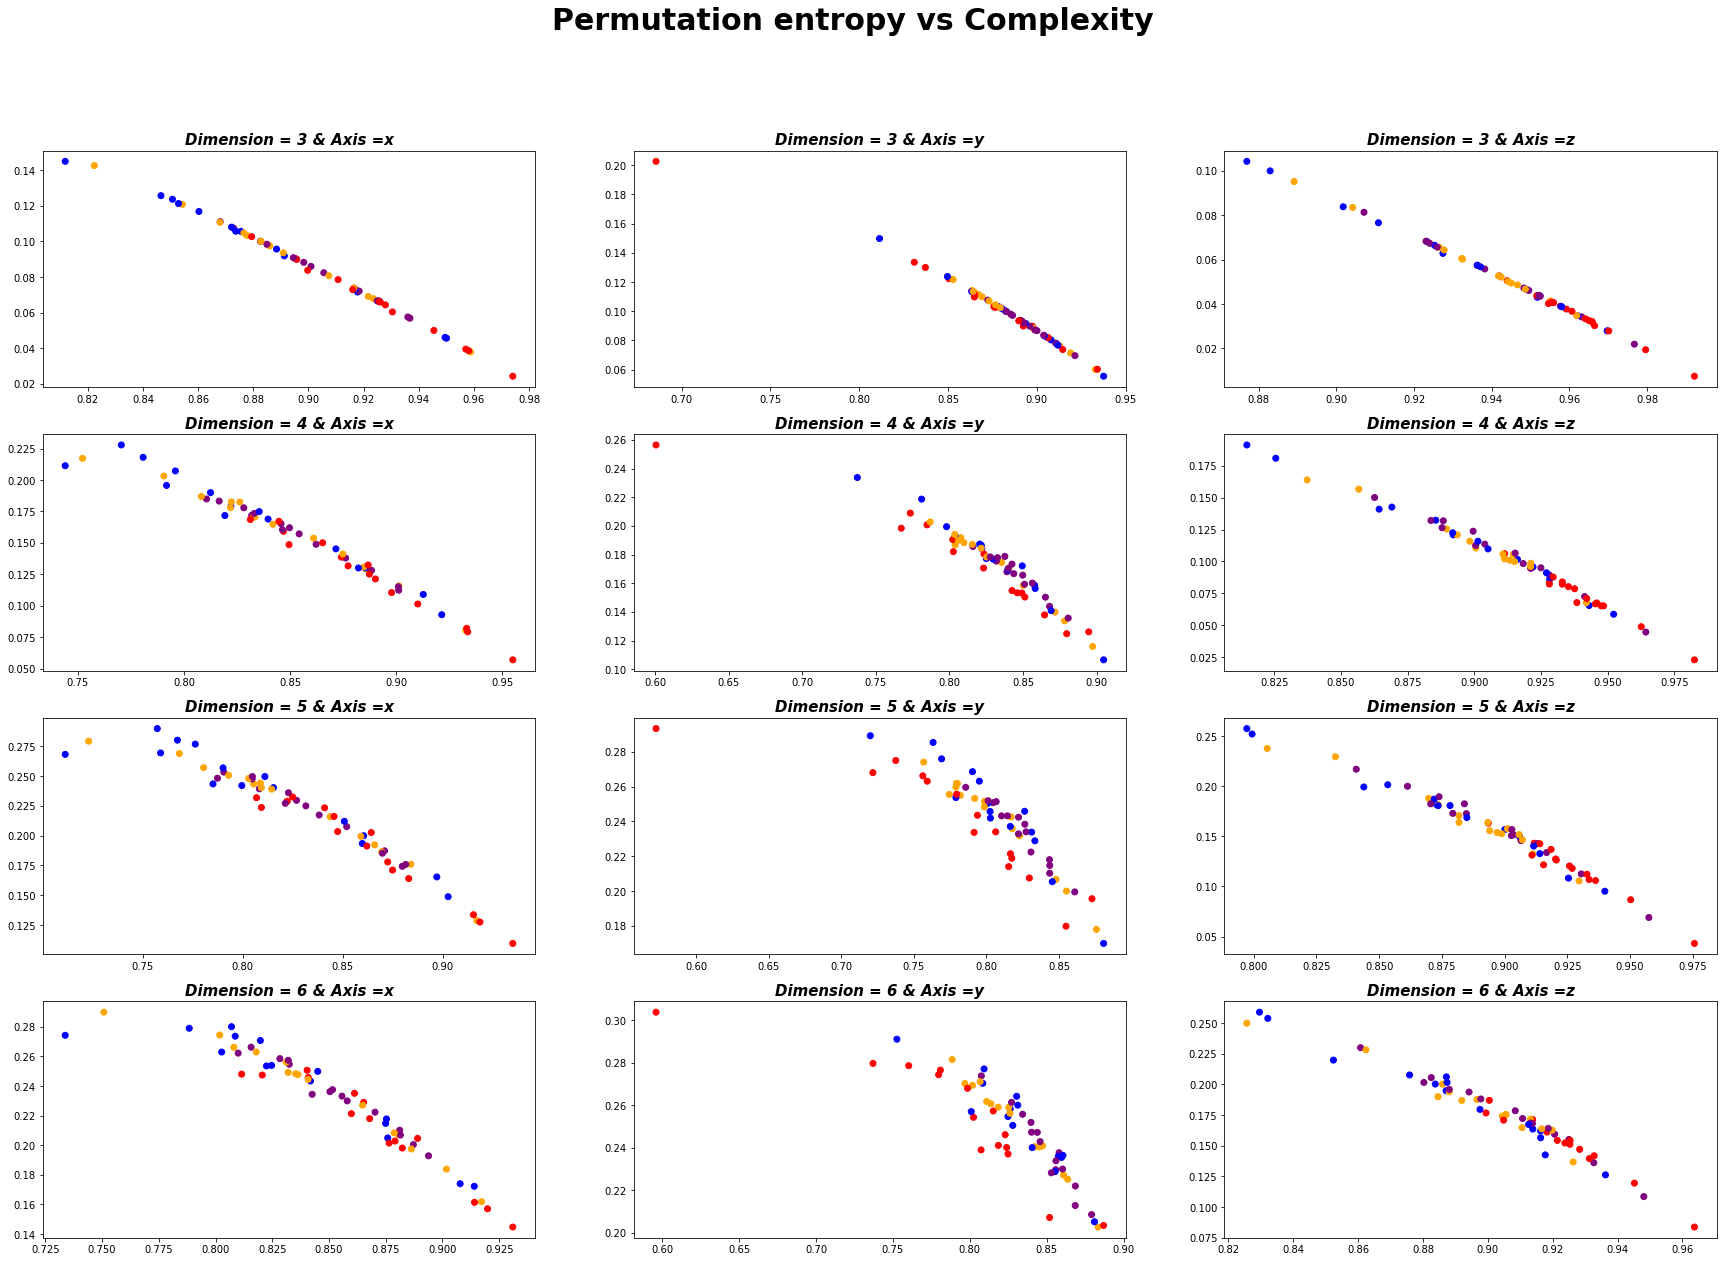

In [ ]:
plot,axis = plt.subplots(4,3,figsize=(30,20))
plot.suptitle("Permutation entropy vs Complexity",size=30, weight="bold", color="black")
A = ["x","y","z"]
Dimension =[3,4,5,6]
Activity =["walking","running","climbingup","climbingdown"]
#Colors for different activities
cols={"walking":"blue","running":"red","climbingup":"orange","climbingdown":"purple"}
a=0;
b=0;
for dim in Dimension:
  b=0  
  for ax in A:
    title="Dimension = "+str(dim)+" & Axis ="+ax;
    axis[a,b].set_title(title, fontstyle='italic',size=15, weight="bold", color="black")
    df2=df_task2[(df_task2["Signal Length"]==4096) & (df_task2["Delay"]==1) & (df_task2["Dimension"]==dim) & (df_task2["Accelerometer Axis"]==ax)]
    axis[a,b].scatter(x=df2["Permutation Entropy"], y=df2["Complexity"], c=df2["Activity"].map(cols))
    b+=1
  a+=1      